In [296]:
from glob import glob
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from modules.utilities import str_to_datetime

location_data_path = '../../data/locations/'
photo_metadata_dirpath = '../../data/photo_metadata'
photo_metadata_path = join(photo_metadata_dirpath, 'metadata.hdf')

%reload_ext autoreload
%autoreload 2

In [297]:
# load metadata
metadata = pd.read_hdf(photo_metadata_path, 'data')
metadata = metadata.sort_values('timestamp')

# append GPS data
photo_gps_path = join(photo_metadata_dirpath, 'photo_gps.hdf')
photo_gps = pd.read_hdf(photo_gps_path, 'data')

# assign latitude/longitude
metadata = metadata.join(photo_gps, on='timestamp', lsuffix='_native', rsuffix='_ping')
metadata['latitude'] = metadata.latitude_native.fillna(metadata.latitude_ping)
metadata['longitude'] = metadata.longitude_native.fillna(metadata.longitude_ping)

# exclude unreliable pings
max_dt_ping = 3600/4 # 15 minutes
no_gps_data = (~metadata.geotagged & (metadata.dt_ping >= max_dt_ping))
metadata.loc[no_gps_data, ['latitude', 'longitude']] = float('nan')

# Infer GPS from pings

In [298]:
def compute_timedelta(series, time_column):
    dt = (series.index - series[time_column])
    return dt.apply(lambda x: abs(x.total_seconds()))

In [299]:
min_ping_accuracy = 250 # meters

# load pings
pings_data_path = join(location_data_path, 'pings.hdf')
pings = pd.read_hdf(pings_data_path, 'data')
pings = pings[~pings.index.duplicated()]
pings['time_ping'] = pings.index
pings = pings[pings.accuracy < min_ping_accuracy]

# match photos with nearest ping
photo_times = metadata.time_shot_pst.apply(str_to_datetime)
columns_without_altitude = ['latitude', 'longitude', 'accuracy', 'owner', 'time_ping']
photo_gps = pd.merge_asof(photo_times, pings[columns_without_altitude], left_on='time_shot_pst', right_index=True, direction='nearest')
photo_gps = photo_gps.set_index('time_shot_pst')
photo_gps['dt_ping'] = compute_timedelta(photo_gps, 'time_ping')

In [300]:
np.percentile(photo_gps.dt_ping, 80)

795.7342000000003

Text(0, 0.5, 'Num. photos')

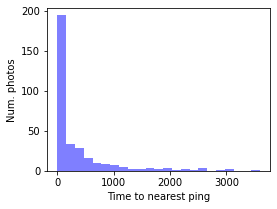

In [301]:
fig, ax = plt.subplots(figsize=(4, 3))
bins = np.linspace(0, 3600*1, 24)
_ = ax.hist(photo_gps.dt_ping, bins=bins, color='b', alpha=0.5)
ax.set_xlabel('Time to nearest ping')
ax.set_ylabel('Num. photos')

In [302]:
# # save photo gps
#photo_gps.to_hdf(join(photo_metadata_dirpath, 'photo_gps.hdf'), 'data')

# Match semantic locations

In [313]:
from scipy import spatial
import numpy as np

from modules.utilities import haversine

def locate_photos(photo_positions, semantic_locations):
    location_positions = semantic_locations[['latitude', 'longitude']].values
    tree = spatial.KDTree(location_positions)
    _, idxs = tree.query(photo_positions, p=1)
    distances = np.array([haversine(p1, p2) for p1, p2 in zip(photo_positions, location_positions[idxs])])   
    return distances, idxs

In [314]:
# load locations
semantic_locations_path = join(location_data_path, 'semantic_locations.hdf')
semantic_locations = pd.read_hdf(semantic_locations_path, 'data')

In [330]:
# match photos to locations
records_without_gps = metadata[metadata.latitude.isna()]
matched_records = metadata[~metadata.latitude.isna()]
photo_positions = matched_records[['latitude', 'longitude']].values
distance_to_semantic, idxs = locate_photos(photo_positions, semantic_locations)
photo_semantic_locations = semantic_locations.iloc[idxs].set_index(matched_records.index)
photo_semantic_locations['distance_to_semantic'] = distance_to_semantic
photo_semantic_locations['album'] = matched_records['album']
photo_semantic_locations['filename'] = matched_records['filename']

In [331]:
def get_caption(record):
    
    max_distance_for_name = 0.5
    max_distance_for_city = 5
    
    if record.distance_to_semantic >= max_distance_for_city:
        return None
    
    elif record.distance_to_semantic >= max_distance_for_name or type(record['name']) != str:
        return record.location_str
    
    else:        
        name = record['name'].title()
        return '{:s} - {:s}'.format(name, record.location_str)    

In [332]:
# assign captions
photo_semantic_locations['caption'] = photo_semantic_locations.apply(get_caption, axis=1)
photo_semantic_locations['place_id'] = photo_semantic_locations['id']
photo_semantic_locations = photo_semantic_locations.drop('id', axis=1)

In [333]:
# look up missing items with google query

max_distance_for_city = 5
excluded_idx = photo_semantic_locations.distance_to_semantic >= max_distance_for_city
missing = photo_semantic_locations[excluded_idx]

# QUERY GOOGLE PLACES API
# responses = {}
# for idx, gps in metadata.loc[missing.index][['latitude', 'longitude']].iterrows():
#     response = gmaps.reverse_geocode(gps.values)
#     responses[metadata.loc[idx].path] = response

# import json
# with open(join(photo_metadata_dirpath, 'gmaps_results.json'), 'w') as file:
#     json.dump(responses, file)

In [334]:
with open(join(photo_metadata_dirpath, 'gmaps_results.json'), 'r') as file:
    geocodes = json.load(file)

records = []
for image_path, geocode in geocodes.items():
    for location in geocode:
        place_id = location['place_id']
        address = location['formatted_address']
        latitude = location['geometry']['location']['lat']
        longitude = location['geometry']['location']['lng']
        gps = np.array([latitude, longitude])
        record = dict(image_path=image_path, match_gps=gps, 
                      match_address=address, match_place_id=place_id)
        records.append(record)
df = pd.DataFrame(records)

In [341]:
matches = []
for image_path, locations in df.groupby('image_path'):
    image_record = metadata.loc[metadata.path==image_path].iloc[0]
    image_gps = (image_record.latitude, image_record.longitude)
    locations['distance_from_image'] = locations.match_gps.apply(lambda x: haversine(x, image_gps))
    match = locations.iloc[locations.distance_from_image.argmin()]
    
    matches.append(
        {
        'image_path': image_path,
        'album': image_record.album,
        'filename': image_record.filename,
        'gps': match.match_gps,
        'address': match.match_address,
        'place_id': match.match_place_id,
        'distance_from_image': match.distance_from_image}    
    )

matches = pd.DataFrame(matches, index=missing.index)

/Users/Sebi/.virtualenvs/web/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [342]:
from modules.utilities import fmt_address
from modules.places import get_city_name, get_country_code, get_state_code, get_location_str

address_data = pd.DataFrame.from_records(matches.address.apply(fmt_address).values.tolist(), index=matches.index)
matches = matches.join(address_data)

# parse city/country
matches['city'] = matches.apply(get_city_name, axis=1)
matches['country_code'] = matches.country.apply(get_country_code)
matches['state_code'] = matches.apply(get_state_code, axis=1)
matches['caption'] = matches.apply(get_location_str, axis=1)

In [347]:
keys = ['album', 'filename', 'city', 'state', 'country', 'caption', 'place_id']
photo_locations = pd.concat((photo_semantic_locations[~excluded_idx][keys], matches[keys]))
photo_locations.to_hdf(join(photo_metadata_dirpath, 'photo_locations.hdf'), 'data')

/Users/Sebi/.virtualenvs/web/lib/python3.6/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['album', 'filename', 'city', 'state', 'country', 'caption', 'place_id'], dtype='object')]

  encoding=encoding,


# GoogleMap API

In [59]:
import googlemaps
from datetime import datetime

gmaps = googlemaps.Client(key=key)

In [61]:
responses = {}
for idx, record in metadata.iterrows():
    if None in record.gps:
        continue
    
    response = gmaps.reverse_geocode(record.gps)
    responses[record.path] = response

In [63]:
import json

# with open('./location_data.json', 'w') as file:
#     json.dump(responses, file)

# Parse responses

In [1]:
import json
with open('./data/location_data.json', 'r') as file:
    responses = json.load(file)

In [6]:
import pandas as pd

def parse_response(url, response):
    
    missing_keys = [
        'country',
        'administrative_area_level_1', 
        'administrative_area_level_2', 
        'administrative_area_level_3', 
        'administrative_area_level_4',
        'locality',
        'route']

    acquired = {'url': url}
    for entry in response:
        for component in entry['address_components']:
            for i, key in enumerate(missing_keys):
                if key in component['types']:        
                    key = missing_keys.pop(i)                
                    acquired[key] = component['short_name']
                    
    return acquired

def fmt_address(record):
    
    if record.locality is None:
        caption = record.country
    
    elif record.administrative_area_level_1 is None:
        caption = '{:s}, {:s}'.format(record.locality, record.country)
        
    else:
        caption = '{:s}, {:s}'.format(record.locality, record.administrative_area_level_1)
            
    return caption

In [7]:
df = pd.DataFrame([parse_response(url, response) for url, response in responses.items()])
df[df.isna()] = None
df['address'] = df.apply(fmt_address, axis=1)
df['city'] = df.locality
df['state'] = df.administrative_area_level_1

In [52]:
metadata = pd.merge(metadata, df[['url', 'address', 'country', 'state', 'city']], how='left', left_on='path', right_on='url')

# Shift timestamps and interpolate locations

In [131]:
from datetime import datetime, timedelta

country_tshifts = {'IT': 9, 'FR': 9, 'GB': 8, 'CZ': 9, 'DE': 9, 'AT': 9, 'SI': 9, 'HR': 9, 'ES': 9, 'MA': 8}
state_tshifts = {'CA': 0, 'NV': 0, 'UT': 1, 'WY': 1, 'MT': 1, 'ID': 1}

def correct_time(record, fmt='%Y:%m:%d %H:%M:%S'):
    time_shot = datetime.strptime(record.time_shot, fmt)
    if record.country == 'US':
        dt = timedelta(hours=state_tshifts[record.state])
    else:
        
        if record.country not in country_tshifts.keys():
            print(record)
            raise ValueError
        
        dt = timedelta(hours=country_tshifts[record.country])
    us_time_shot = time_shot - dt
    return us_time_shot.strftime(fmt)
    
def get_us_time(record):
    if None in record.gps:
        return record.time_shot
    else:
        us_time_shot = correct_time(record)
        return us_time_shot

In [ ]:
metadata['time_shot_pacific'] = metadata.apply(get_us_time, axis=1)
metadata = metadata.sort_values(by='time_shot_pacific')

In [171]:
import numpy as np
tagged, untagged = metadata[metadata.geotagged], metadata[~metadata.geotagged]
idxs = np.searchsorted(tagged.time_shot_pacific.values, untagged.time_shot_pacific.values)
for attr in ['city', 'state', 'country', 'address']:
    metadata.loc[untagged.index, attr] = tagged.iloc[idxs][attr].values

In [190]:
from exif import Image as ExifImage
from iptcinfo3 import IPTCInfo



def parse(filepath):

    with open(filepath, 'rb') as file:
        exif = ExifImage(file)
    time_shot_local = exif.datetime_original
        
    iptc = IPTCInfo(filepath)
    keywords = [str(x, 'utf-8') for x in iptc['keywords']]
    for tz in ['pst', 'mst', 'gmt', 'cet']:
        if tz in keywords:
            break
    time_shot_pacific = localize(time_shot_local, tz)
    
    try:
        gps = [to_dd(*exif.gps_latitude), -to_dd(*exif.gps_longitude)]
    except:
        gps = None
    
    return {
        'url': filepath,
        'time_local': time_shot_local,
        'time_pacific': time_shot_pacific,        
        'gps': gps}

In [201]:
import warnings
warnings.simplefilter('ignore')

dirpaths = [
    '/Volumes/bernasek_t5/photos/original/phone',
    '/Volumes/bernasek_t5/photos/original/xtina_phone'
] 

records = []
for dirpath in dirpaths:
    for filepath in glob(join(dirpath, '*.JPG')):
        try:
            record = parse(filepath)
            records.append(record)
        except:
            continue

In [203]:
import pandas as pd
df = pd.DataFrame(records)
df.to_hdf('./data/phone.hdf', 'data')

In [210]:
df = df.sort_values(by='time_pacific')

In [212]:
jpeg_data = df
jpeg_data = jpeg_data[jpeg_data.gps.apply(lambda x: type(x)==list)]

In [234]:
jpeg_data[['latitude','longitude']] = pd.DataFrame(jpeg_data.gps.values.tolist(), index=jpeg_data.index)